In [9]:
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
%matplotlib inline

# Import and process data

In [10]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    # Replace outlier reading 138 (far far too big!)
    classData[138] = classData[137]
    coilData[138] = coilData[137]
    
    return classData, coilData

def processCoilData(coilData, expand):
    """
    The coil data is an array of shape [400,15,2000] (1 second @ 1GHz for a set of 15 SQUIDs for 
    400 total runs on a group of 60 heathy and 60 unhealthy patients). 
    
    This function first reduces the coil data to every 40th point, without a major loss of information. 
    If expand == True, then it then iterates over the dataset, taking every 40th point from a starting 
    position of i=1,2,3,...,40. 
    In this way we can artificially expand each individual set of coilData into 40 similar sets.
    
    Returns an array of shape [40*400,750] if expand == True, or shape [400, 750] if expand == False.
    """
    #coilData = [x*10000 for x in coilData]
    
    if expand == True:
        # Initialise expanded data array.
        coilDataCut = np.zeros((16000, 750))

        for j in np.arange(0,40,1):
            for i in np.arange(0,400,1):
                coilDataCut[i+(j*400)] = np.hstack(coilData[i])[j::40]
        
        return coilDataCut
    if expand == False:
        coilDataCut = np.zeros((400,750))
        
        for i in np.arange(0,400,1):
            coilDataCut[i] = np.hstack(coilData[i])[0::40]
            
        return coilDataCut

def processClassData(classData, expand):
    """
    Process classData to complement that of the data processed by processCoilData.
    
    Returns a one-hot array of shape [40*400,2] if expand == True, and an array of shape
    [400,2] if expand == False.
    """
    # Convert label data to one-hot array
    classDataOH = np.zeros((400,2))
    classDataOH[np.arange(400), classData.astype(np.int)] = 1
    if expand == True:
        classDataOH = np.tile(classDataOH, (40, 1))
    
    return classDataOH

def getGraphs(coilData):
    """
    Plot heatmap and line graph of data.
    Output ./outData/heatmap.pdf and ./outData/graphmap.pdf
    """
    plt.imshow(coilData, cmap='hot', interpolation='nearest')
    plt.title("Heatmap of entire dataset")
    plt.xlabel("Reading #")
    plt.ylabel("Patient #")

    plt.savefig("./outData/heatmap.pdf")
    plt.clf()
    
    for i in np.arange(0,400,1):
        plt.plot(coilData[i])
    plt.title("Graph of entire dataset")
    plt.xlabel("Reading #")
    plt.ylabel("SQUID reading amplitude")
    
    plt.savefig("./outData/graphmap.pdf")
    plt.clf()

In [50]:
classData, coilData = importPickle("./inData/6060DataFrame.pkl")
expand = False
coilData = processCoilData(coilData, expand)
coilData = np.absolute(coilData)
classData = processClassData(classData, expand)
getGraphs(coilData[:400])

In [51]:
coilDataRS = np.absolute(np.reshape(coilData,[400,15,50,1]))

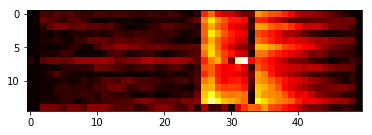

In [52]:
plt.imshow(coilDataRS[0,:,:,0], cmap='hot', interpolation='nearest')

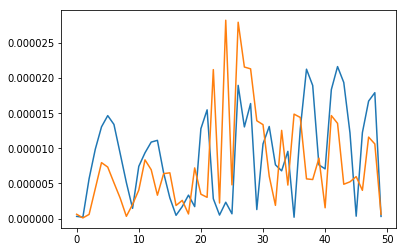

In [53]:
plt.plot(np.absolute(coilData[1,0:50]))
plt.plot(np.absolute(coilData[1,50:100]))

# Neural Network

In [62]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 15, 50, 1])

# First layer:
net = tflearn.layers.conv.conv_2d(net, 128, [5,5], activation="relu")
net = tflearn.layers.conv.max_pool_2d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_2d(net, 256, [5,5], activation="relu")
net = tflearn.layers.conv.max_pool_2d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 2048, activation="relu")

# Fully connected layer 2:
net = tflearn.layers.core.fully_connected(net, 256, activation="relu")

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='binary_crossentropy',\
                         learning_rate=0.001)

In [63]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(coilDataRS, classData)
model.fit(coilDataRS, classData, validation_set=0.1)

Training Step: 130  | total loss: 0.72382
| Adam | epoch: 010 | loss: 0.72382 | val_loss: 0.72329 -- iter: 360/360
Training Step: 130  | total loss: 0.72382
| Adam | epoch: 010 | loss: 0.72382 | val_loss: 0.72329 -- iter: 360/360
--
